In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os

def gaussian_kernel(kernel_size, sigma):
    x = torch.arange(kernel_size) - (kernel_size - 1) / 2.0
    kernel = torch.exp(-0.5 * (x / sigma)**2)
    kernel /= kernel.sum()  # Normalize
    return kernel.view(1, 1, -1) 

def preprocess_fft(signal, target_length):
    # Pad or truncate to make signal length consistent
    signal_length = signal.size(0)
    if signal_length < target_length:
        # Zero-pad shorter sequences
        padded_signal = F.pad(signal, (0, 0, 0, target_length - signal_length))
    else:
        # Truncate longer sequences
        padded_signal = signal[:target_length]
    return padded_signal

feature_dir = '/home/henry/robo/cis5810/final/cis5810_final_gait_classifier/data/gavd_dataset/landmarks_new'
all_features = []
files = [f for f in os.listdir(feature_dir) if f.endswith('.pt')]
for file in files:
    file_path = os.path.join(feature_dir, file)
    # Load DINO features and get metadata
    features = torch.load(file_path)
    # Normalize the features
    features = (features - features.mean()) / features.std()

    # smooth the features with a 1D Gaussian kernel
    kernel = gaussian_kernel(5, 1.0)

    features = features.unsqueeze(0)
    features = features.permute(2, 0, 1)  # Shape: [batch_size, num_channels, signal_length] --> [1, 66, 151]
    print(features.shape)
    features = F.conv1d(features, kernel, padding=2)
    features = features.permute(1, 2, 0)
    features = features.squeeze(0)
    print(features.shape)

    # Perform 120-point FFT on the features
    freqs = torch.fft.fftfreq(120, d=1/30)  # Frequency bins
    freq_mask = (freqs <= 1) & (freqs >= 0.0)

    features = preprocess_fft(features, 120)
    print(features.shape)

    fft = torch.fft.fft(features, dim=0)
    fft = torch.abs(fft)
    fft = fft[freq_mask, :]
    freqs = freqs[freq_mask]
    print(freqs)
    fft = fft.flatten()
    print(fft.shape)
    all_features.append(fft)





/home/henry/robo/cis5810/final/cis5810_final_gait_classifier/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([66, 1, 100])
torch.Size([100, 66])
torch.Size([120, 66])
tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])
torch.Size([330])
torch.Size([66, 1, 212])
torch.Size([212, 66])
torch.Size([120, 66])
tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])
torch.Size([330])
torch.Size([66, 1, 90])
torch.Size([90, 66])
torch.Size([120, 66])
tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])
torch.Size([330])
torch.Size([66, 1, 343])
torch.Size([343, 66])
torch.Size([120, 66])
tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])
torch.Size([330])
torch.Size([66, 1, 161])
torch.Size([161, 66])
torch.Size([120, 66])
tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])
torch.Size([330])
torch.Size([66, 1, 110])
torch.Size([110, 66])
torch.Size([120, 66])
tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])
torch.Size([330])
torch.Size([66, 1, 253])
torch.Size([253, 66])
torch.Size([120, 66])
tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])
torch.Size([330])
torch.Size([66, 1, 1108])
torch.Size([1108, 66])
t

1502
torch.Size([330])
torch.Size([1502, 330])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(330,)


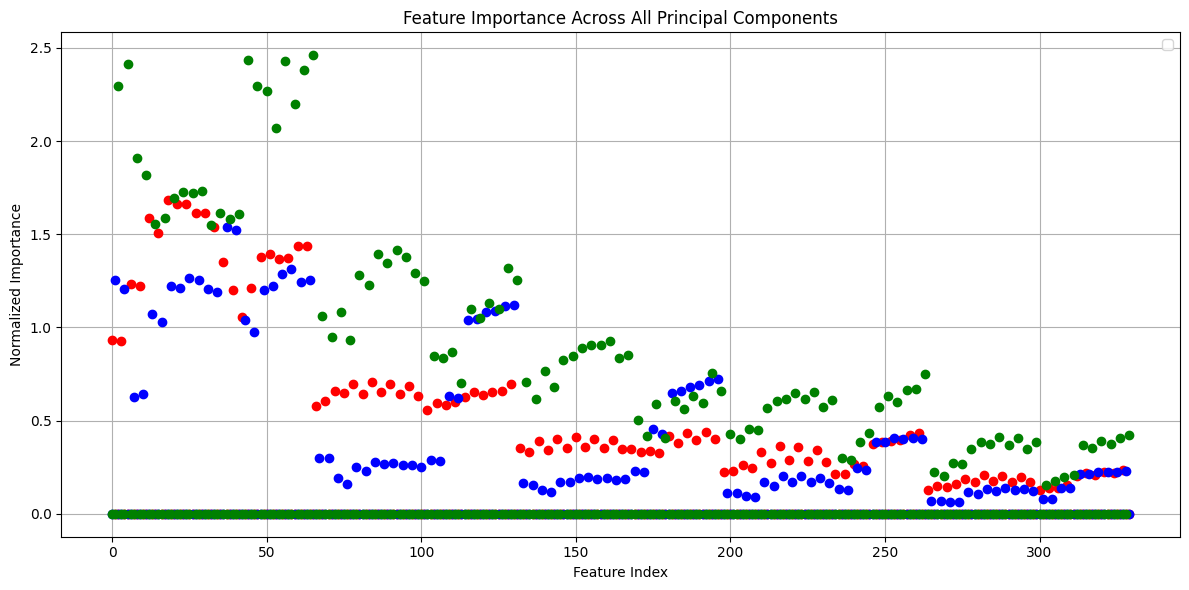

In [2]:
import matplotlib.pyplot as plt

print(len(all_features))
print(all_features[0].shape)
all_features = torch.stack(tuple(all_features))
print(all_features.shape)
# do PCA using sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(all_features)

importance = np.sum(np.abs(pca.components_), axis=0)

red = np.zeros_like(importance)
blue = np.zeros_like(importance)
green = np.zeros_like(importance)
for i in range(len(importance)):
    if i % 3 == 0:
        red[i] = importance[i]
    elif i % 3 == 1:
        blue[i] = importance[i]
    else:
        green[i] = importance[i]
        
# Plot feature importances as dots not lines
# alternate dot colors red, blue, green
plt.figure(figsize=(12, 6))
plt.plot(red, 'o', color='red')
plt.plot(blue, 'o', color='blue')
plt.plot(green, 'o', color='green')
plt.xlabel("Feature Index")
plt.ylabel("Normalized Importance")
plt.title("Feature Importance Across All Principal Components")
plt.grid()
plt.tight_layout()
plt.show()


